In [2]:
# Import packages
import pandas as pd
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import json

In [3]:
# Load the business.json file
with open("C:\\Users\\Raymond Loh\\OneDrive\\Documents\\yelp_academic_dataset_business.json", encoding="utf-8") as dataset_business:
    data = [json.loads(line) for line in dataset_business]
# Create DataFrame from the loaded data
df_b = pd.DataFrame(data)

In [4]:
# Filter the DataFrame to include only businesses that are still open
df_b = df_b[df_b['is_open'] == 1]
# Split the categories and explode them into separate rows, then filter for coffee-related categories
df_explode = df_b.assign(categories=df_b.categories.str.split(', ')).explode('categories')
coffee_categories = df_explode[df_explode.categories.str.contains('Coffee', case=True, na=False)]
# Count the occurrences of coffee-related categories
coffee_category_counts = coffee_categories.categories.value_counts()
# Further filter the original DataFrame for specific coffee-related business categories
business_coffee = df_b[df_b['categories'].str.contains(
    'Coffee & Tea|Coffee Roasteries|Coffeeshops|Coffee & Tea Supplies',
    case=False, na=False)]

In [5]:
# Define the path to the Yelp review dataset
review_json_path = 'C:\\Users\\Raymond Loh\\OneDrive\\Documents\\yelp_academic_dataset_review.json'
# Define the chunk size for processing the data
size = 1000000
# Initialize a list to store processed chunks
chunk_list = []
# Load the dataset in chunks and process each chunk
for chunk in pd.read_json(review_json_path, lines=True, 
                          dtype={'review_id': str, 'user_id': str, 'business_id': str, 
                                 'stars': int, 'date': str, 'text': str, 
                                 'useful': int, 'funny': int, 'cool': int}, 
                          chunksize=size):
    # Drop unnecessary columns from the chunk
    chunk = chunk.drop(['review_id', 'useful', 'funny', 'cool'], axis=1)
    # Rename the 'stars' column to 'review_stars' to avoid conflicts
    chunk = chunk.rename(columns={'stars': 'review_stars'})
    # Merge the chunk with the business dataset to keep only relevant reviews
    chunk_list.append(pd.merge(business_coffee, chunk, on='business_id', how='inner'))
# Concatenate all processed chunks into a single DataFrame
df = pd.concat(chunk_list, ignore_index=True)
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [8]:
# Get the number of reviews by each rating stars

import json
import pandas as pd
from pandasql import sqldf

# Assume df is your DataFrame
df['attributes'] = df['attributes'].apply(json.dumps)
df['categories'] = df['categories'].apply(json.dumps)
df['hours'] = df['hours'].apply(json.dumps)

# Execute SQL query
pysqldf = lambda q: sqldf(q, globals())

a1 = pysqldf("""
    SELECT stars, SUM(review_count) as review_count
    FROM df
    GROUP BY stars
    ORDER BY review_count DESC
""")
print(a1)

   stars  review_count
0    4.5      81885190
1    4.0      63937405
2    3.5       8069977
3    5.0       1693202
4    3.0       1603069
5    2.5       1172676
6    2.0        500721
7    1.5        439812
8    1.0         63987


Text(0.5, 1.0, 'Reviews by Ratings')

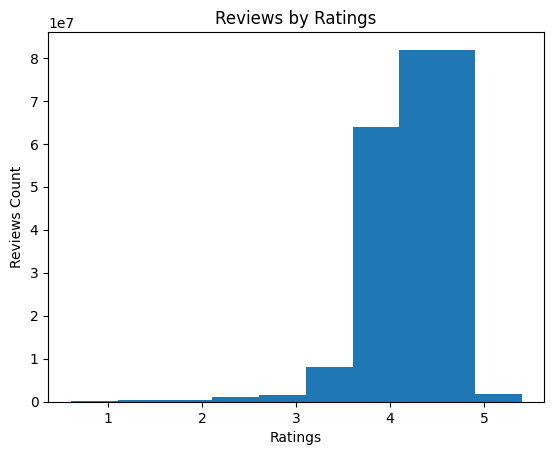

In [11]:
# Plot distribution of review ratings against the number of reviews
x = a1.stars
y = a1.review_count

plt.bar(x,y,align='center')
plt.xlabel('Ratings')
plt.ylabel('Reviews Count')
plt.title('Reviews by Ratings')

In [67]:
# List the cities with average review rating

pysqldf("""
    SELECT city, AVG(review_stars) as avg_rating, COUNT(*) as total_review
    FROM df
    GROUP BY city
    HAVING COUNT(*) > 500
    ORDER BY avg_rating
    """)

,city,avg_rating,total_review
0,Bryn Mawr,3.089744,624
1,Brandon,3.356757,925
2,Plant City,3.471795,585
3,Brentwood,3.477364,1502
4,Gretna,3.479032,620
...,...,...,...
61,Media,4.185567,1164
62,Saint Petersburg,4.317308,7904
63,Clayton,4.356338,710
64,Madeira Beach,4.389573,1055


In [17]:
# List the coffee company popular operating hour

pd.set_option('display.max_colwidth', None)
pysqldf("""SELECT hours, AVG(stars) as avg_rating, SUM(review_count) as review_count
        FROM df
        GROUP BY hours
        ORDER BY review_count DESC, avg_rating DESC
        LIMIT 5
        """)

,hours,avg_rating,review_count
0,"{""Monday"": ""8:0-18:0"", ""Tuesday"": ""8:0-18:0"", ""Wednesday"": ""8:0-18:0"", ""Thursday"": ""8:0-18:0"", ""Friday"": ""8:0-18:0"", ""Saturday"": ""8:0-18:0"", ""Sunday"": ""8:0-18:0""}",4.440349,33318333
1,"{""Monday"": ""0:0-0:0"", ""Tuesday"": ""7:0-15:0"", ""Wednesday"": ""7:0-15:0"", ""Thursday"": ""7:0-15:0"", ""Friday"": ""7:0-17:0"", ""Saturday"": ""7:0-17:0"", ""Sunday"": ""7:0-15:0""}",4.000000,7316736
2,"{""Monday"": ""7:0-21:0"", ""Tuesday"": ""7:0-21:0"", ""Wednesday"": ""7:0-21:0"", ""Thursday"": ""7:0-21:0"", ""Friday"": ""7:0-21:0"", ""Saturday"": ""7:0-21:0"", ""Sunday"": ""7:0-21:0""}",4.172897,4480866
3,"{""Monday"": ""12:0-0:0"", ""Tuesday"": ""11:0-23:45"", ""Wednesday"": ""12:0-0:0"", ""Thursday"": ""12:0-0:0"", ""Friday"": ""12:0-0:0"", ""Saturday"": ""12:0-0:0"", ""Sunday"": ""12:0-0:0""}",4.000000,4330200
4,"{""Monday"": ""8:0-14:0"", ""Tuesday"": ""8:0-14:0"", ""Wednesday"": ""8:0-14:0"", ""Thursday"": ""8:0-14:0"", ""Friday"": ""8:0-14:0"", ""Saturday"": ""8:0-14:0"", ""Sunday"": ""8:0-14:0""}",4.090698,4288555


In [18]:
pd.reset_option('display.max_colwidth')
df.text.head()

0    This is nice little Chinese bakery in the hear...
1    This is the bakery I usually go to in Chinatow...
2    A delightful find in Chinatown! Very clean, an...
3    I ordered a graduation cake for my niece and i...
4    HK-STYLE MILK TEA:  FOUR STARS\n\nNot quite su...
Name: text, dtype: object

In [20]:
# Get list of english stopwords (ref: https://gist.github.com/sebleier/554280)

stopwords = [
    'i',
    'me',
    'my',
    'myself',
    'we',
    'our',
    'ours',
    'ourselves',
    'you',
    'your',
    'yours',
    'yourself',
    'yourselves',
    'he',
    'him',
    'his',
    'himself',
    'she',
    'her',
    'hers',
    'herself',
    'it',
    'its',
    'itself',
    'they',
    'them',
    'their',
    'theirs',
    'themselves',
    'what',
    'which',
    'who',
    'whom',
    'this',
    'that',
    'these',
    'those',
    'am',
    'is',
    'are',
    'was',
    'were',
    'be',
    'been',
    'being',
    'have',
    'has',
    'had',
    'having',
    'do',
    'does',
    'did',
    'doing',
    'a',
    'an',
    'the',
    'and',
    'but',
    'if',
    'or',
    'because',
    'as',
    'until',
    'while',
    'of',
    'at',
    'by',
    'for',
    'with',
    'about',
    'against',
    'between',
    'into',
    'through',
    'during',
    'before',
    'after',
    'above',
    'below',
    'to',
    'from',
    'up',
    'down',
    'in',
    'out',
    'on',
    'off',
    'over',
    'under',
    'again',
    'further',
    'then',
    'once',
    'here',
    'there',
    'when',
    'where',
    'why',
    'how',
    'all',
    'any',
    'both',
    'each',
    'few',
    'more',
    'most',
    'other',
    'some',
    'such',
    'no',
    'nor',
    'not',
    'only',
    'own',
    'same',
    'so',
    'than',
    'too',
    'very',
    's',
    't',
    'can',
    'will',
    'just',
    'don',
    'should',
    'now',
    '&amp;',
    '',
    '_',
    'back',
    'got',
    'go',
    'really',
    'one',
    "it's",
    'would',
    'also',
    "i've",
    "i'm",
    'get',
    '-',
    "don't",
    'even',
    'said',
    'asked',
    'went',
    'us',
    'like',
    'ordered',
    'good',
    'two'
]

sw_df = pd.DataFrame(stopwords, columns=['stopword'])

In [57]:
# Separate dataset into two dataframe, one with ratings >= 4, one with ratings < 3
high_rating_review = pysqldf("""SELECT text, review_stars
                                FROM df
                                WHERE review_stars >= 4
                                """)

low_rating_review = pysqldf("""SELECT text, review_stars
                                FROM df
                                WHERE review_stars < 3
                                """)

Word frequency dictionary:
 [('coffee', 121954), ('place', 105005), ('great', 101577), ('good', 70606), ('food', 67076), ('like', 61529), ('get', 60292), ('one', 57203), ('love', 55491), ('also', 54445), ('really', 53008), ('go', 47277), ('always', 44603), ('best', 44343), ('time', 41320), ('little', 40848), ('definitely', 40544), ('would', 40319), ('back', 40206), ("i've", 39357)]


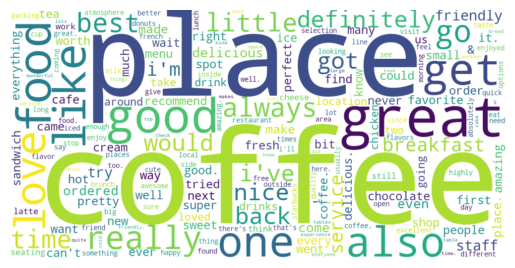

In [59]:
# Remove stopwords and lowercase text
no_sw = high_rating_review['text'].apply(
    lambda text: [word.lower() for word in text.split() if word.lower() not in stopwords_set]
)

# Flatten list and count word frequencies
corpus = [word for sublist in no_sw for word in sublist]
wordDict = Counter(corpus)

# Debug print
print("Word frequency dictionary:\n", wordDict.most_common(20))

# Generate and display the word cloud
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    collocations=False,  # Avoid multiple occurrences of the same word
    max_words=200        # Limit the number of words displayed
).generate_from_frequencies(wordDict)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Word frequency dictionary:
 [('get', 26182), ('one', 24241), ('like', 24229), ('food', 24133), ('order', 23087), ('coffee', 22931), ('place', 20337), ('time', 19102), ('go', 18589), ('would', 17801), ('even', 16269), ('service', 16054), ('ordered', 15992), ('got', 15368), ('back', 14367), ('never', 14286), ('asked', 13310), ('minutes', 12928), ('said', 12581), ("i'm", 12264)]


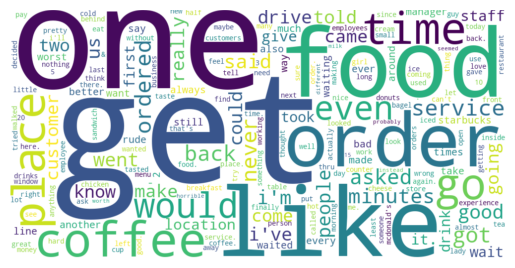

In [58]:
# Remove stopwords and lowercase text
no_sw = low_rating_review['text'].apply(
    lambda text: [word.lower() for word in text.split() if word.lower() not in stopwords_set]
)

# Flatten list and count word frequencies
corpus = [word for sublist in no_sw for word in sublist]
wordDict = Counter(corpus)

# Debug print
print("Word frequency dictionary:\n", wordDict.most_common(20))

# Generate and display the word cloud
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    collocations=False,  # Avoid multiple occurrences of the same word
    max_words=200        # Limit the number of words displayed
).generate_from_frequencies(wordDict)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [62]:
# List the coffee company popular operating hour

pd.set_option('display.max_colwidth', None)
pysqldf("""SELECT hours, is_open, AVG(stars) as avg_rating, SUM(review_count) as review_count
        FROM df
        GROUP BY hours
        ORDER BY review_count, avg_rating
        LIMIT 5
        """)

,hours,is_open,avg_rating,review_count
0,"{""Monday"": ""5:0-18:0"", ""Tuesday"": ""5:0-18:0"", ""Wednesday"": ""5:0-18:0"", ""Thursday"": ""5:0-18:0"", ""Friday"": ""5:0-18:0"", ""Saturday"": ""5:0-18:0"", ""Sunday"": ""6:0-17:0""}",1,1.0,25
1,"{""Monday"": ""0:0-0:0"", ""Tuesday"": ""9:30-19:0"", ""Wednesday"": ""9:30-19:0"", ""Thursday"": ""9:30-19:0"", ""Friday"": ""9:30-19:0"", ""Saturday"": ""9:30-19:0"", ""Sunday"": ""10:30-18:0""}",1,2.0,25
2,"{""Monday"": ""6:0-0:0"", ""Tuesday"": ""6:0-0:0"", ""Wednesday"": ""6:0-0:0"", ""Thursday"": ""6:0-0:0"", ""Friday"": ""5:0-4:0"", ""Saturday"": ""5:0-4:0"", ""Sunday"": ""6:0-0:0""}",1,2.0,25
3,"{""Monday"": ""6:0-21:0"", ""Tuesday"": ""6:0-21:0"", ""Wednesday"": ""6:0-21:0"", ""Thursday"": ""6:0-21:0"", ""Friday"": ""6:0-0:0"", ""Saturday"": ""6:0-0:0"", ""Sunday"": ""6:0-21:0""}",1,2.0,25
4,"{""Monday"": ""7:0-19:0"", ""Tuesday"": ""7:0-19:0"", ""Wednesday"": ""7:0-19:0"", ""Thursday"": ""7:0-19:0"", ""Friday"": ""7:0-19:0""}",1,2.5,25
